<a href="https://colab.research.google.com/github/migperfer/AMPL-UPF-MSC/blob/master/Check%20usuls_makams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check if is executing on Google Colab
If running on google colab download the repositories

In [8]:
try:
  import google.colab
  !git clone --recursive https://github.com/migperfer/AMPL-UPF-MSC
  IN_COLAB = True
except:
  IN_COLAB = False

fatal: destination path 'AMPL-UPF-MSC' already exists and is not an empty directory.


# Import libraries

In [0]:
from music21 import *
from music21.note import Note as noteclass
from music21.chord import Chord as chordclass
from music21.meter import TimeSignature as tsclass
import os, glob, math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Creation of Usul related objects
## Definition of the UsulStroke and Usul classes

In [0]:
class UsulStroke:
  def __init__(self, mnote, stroke, barduration):    
    self.stroketype = stroke.content
    self.duration = mnote.duration.quarterLength
    self.offset = mnote.beat
    self.barduration = barduration
    self.compatoffset = float(str(float((mnote.beat - 1)/barduration))[:4])
    if isinstance(mnote, chordclass):
      self.hand = "both"
    elif mnote.pitch.name == "F":
      self.hand = "right"
    elif mnote.pitch.name == "D":
      self.hand = "left"
    else:
      self.hand = "unknown"

  def __repr__(self):
    return "UsulStroke"

  def __str__(self):
    return "Stroke:%s, Duration:%s, Hand:%s, Offset:%s" % (self.stroketype, self.duration, self.hand, self.compatoffset)

class Usul:
  def __init__(self, usulname, strokes, nbeats):
    self.nbeats = nbeats
    self.usul = usulname
    self.strokes = strokes

  @classmethod
  def usul_from_file(cls, file):
    nbeats = 0
    score = converter.parse(file)
    rhythm = score.getElementsByClass('Part')[0].getElementsByClass('Measure')[0]
    notes = []
    for element in rhythm:
      if isinstance(element, (noteclass, chordclass)):
        notes.append(element)
      if isinstance(element, (tsclass)):
        nbeats = element.beatCount
        
    strokes = rhythm.getElementsByClass('TextExpression')
    usul_name = file.split('/')[-1].split('.mxl')[0].lower().replace('_', ' ')
    strokes_list = []
    for note in range(len(notes)):
      strk = UsulStroke(notes[note], strokes[note], nbeats)
      strokes_list.append(strk)
    return cls(usul_name, strokes_list, nbeats)


  def __iter__(self):
    self.index = 0
    return self

  def __getitem__(self, idx):
        return self.strokes[idx]

  def __next__(self):
    if self.index < len(self.strokes):
      idx = self.index
      self.index += 1
      return self.strokes[idx]
    else:
      raise StopIteration

  def _repr__(self):
    return "Usul"
  
  def __str__(self):
    return "Usul Object: %s" % (self.usul)

## Load all existing usuls with the classes created in last cell

We load all the usuls possible (the ones for which we have the scores), into the *usul_dict* dictionary

In [0]:
if IN_COLAB:
    usuls_files_list = glob.glob('./AMPL-UPF-MSC/scores/mxl/*.mxl')
else:
    usuls_files_list = glob.glob('./scores/mxl/*.mxl')

usuls_dict = {}
for usul_file in usuls_files_list:
  usul_name = usul_file.split('/')[-1].split('.mxl')[0].lower().replace('_', ' ')
  if '\\' in usul_name:  # Windows use \ instead of /
        usul_name = usul_name.split('\\')[-1]
  usuls_dict[usul_name] = Usul.usul_from_file(usul_file)

## Load define makams functions

In [0]:
usuldict = {'sofyan':0,'duyek':1,'raksaksagi':2,'cenber':3,'hafif':4,'devrikebir':5,'muhammes':6,'turkaksagi':7,'oynak':8,'havi':9,'aksak':10,'yuruksemai':11,'berefsan':12,'aksaksemai':13,'fahte':14,'semai':15,'cifteduyek':16,'evfer':17}
makamlist = ['hicaz','rast','nihavent','ussak','segah','huseyni','huzzam','mahur','kurdilihicazkar','muhayyer']
makamdict = {makamlist[i]:i for i in range(len(makamlist))}

rast = {'G': 1, 'A': 2, 'B':3,'C':4,'D':5,'E':6,'F':7,'Dom':'D5','Lead':'F4#'}
huseyni = {'A': 1, 'B':2,'C':3,'D':4,'E':5,'F':6, 'G':7,'Dom':'E5','Lead':'G4'}
muhayyer = {'A': 1, 'B':2,'C':3,'D':4,'E':5,'F':6, 'G':7,'Dom':'A5','sDom':'E5','Lead':'G4'}
ussak = {'A': 1, 'B':2,'C':3,'D':4,'E':5,'F':6, 'G':7,'Dom':'D5','Lead':'G4'}
hicaz = {'A': 1, 'B':2,'C':3,'D':4,'E':5,'F':6, 'G':7,'Dom':'D5','Lead':'G4'}
huzzam = {'B':1,'C':2,'D':3,'E':4,'F':5, 'G':6,'A':7,'Dom':'D5','Lead':'A4#'}
kurdilihicazkar = {'G': 1, 'A': 2, 'B':3,'C':4,'D':5,'E':6,'F':7,'Dom':'G5','Lead':'F4'} 
nihavent = {'G': 1, 'A': 2, 'B':3,'C':4,'D':5,'E':6,'F':7,'Dom':'D5','Lead':'F4#'}
segah = {'B':1,'C':2,'D':3,'E':4,'F':5, 'G':6,'A':7,'Dom':'D5','Lead':'A4#'}
mahur = {'G': 1, 'A': 2, 'B':3,'C':4,'D':5,'E':6,'F':7,'Dom':'G5','Lead':'F4#'}

if IN_COLAB:
    folder = 'AMPL-UPF-MSC/SymbTr/txt/'
else:
    folder = 'SymbTr/txt/'

allScores = os.listdir(folder)

def getDegree(note,makam):
    significance = None
    degree = eval(makam)[note[0]]
    if degree == 1:
        significance = 'Tonic'
    if note[:2] == eval(makam)['Dom']:
        significance = 'Dominant'
    if note[:2] == eval(makam)['Lead']:
        significance = 'Leading'    
    return degree,significance

def getbars(makam,usul):
    bars = []
    bar = []
    for file in allScores:
        mak,_,us = file.split('--')[:3]
        
        if (mak != makam) or (us != usul):
            continue
        
        with open(folder + file, encoding="utf8") as scoretxt:
            txtlines = scoretxt.read().split('\n')
        for i in range(2,len(txtlines)-1):
            if int(txtlines[i].split('\t')[1])==51: # possible usul change, leave the rest
                break
            if int(txtlines[i].split('\t')[6])>0:
                dur = int(txtlines[i].split('\t')[6])/int(txtlines[i].split('\t')[7])
                notename = txtlines[i].split('\t')[3]
                degree, significance = getDegree(notename,mak)
                offset = txtlines[i].split('\t')[-1]     
                bar.append([offset,dur,notename,degree,significance])
                if float(offset).is_integer():
                    bars.append(bar)
                    bar = []
    return bars

## Function to analyze a makam using an usul object

In [0]:
def analyze_makam(makam_name, usul_name):
    usul_part = usul_name.replace("ü", "u").replace(" ", "").replace("ç","c").replace("ğ","g").replace("ş","s").replace("-","")
    makam_part = makamdict[makam_name]
    makam = getbars(makam_name, usul_part)
    if makam == []:
      raise ValueError("Can't load makam %s-%s" % (makam_name, usul_part))
    usul = usuls_dict[usul_name]
    coincidences = []
    usul_onsets = []
    for stroke in usul:
        usul_onsets.append(stroke.compatoffset)  # Get the position of every stroke in this
    onsets_indx = dict((k,i) for i,k in enumerate(usul_onsets))  # Store the index of every beat position
    for bar in makam:
        for note in bar:
            beat, bar = math.modf(float(note[0]))  # Split the integer part and the decimal one
            beat = beat # Substract the duration, to get the beat position
            beat = float(str(beat)[:4])  # Limit to 4 the number of decimals

            if beat in usul_onsets:
                coinc_stroke = usul[onsets_indx[beat]]  # Get coincident stroke
                coincidence = {'hand': coinc_stroke.hand, 'duration': coinc_stroke.duration, 'stroke': coinc_stroke.stroketype,
                               'note_name': note[2], 'note_degree': note[3], 'note_significance': note[4], 'makam': makam_name, 'usul': usul_name}
                coincidences.append(coincidence)
    coincidences = pd.DataFrame(coincidences)
    return coincidences
            

## Analyze the scores
Analyze the scores and save them into a folder called _csv-data_

In [14]:
if not os.path.isdir('csv-data/'):
  os.mkdir('csv-data/')
import gc
empty_ones = []
broken_ones = []
for usul_key in usuls_dict.keys():
  for makam_key in makamdict.keys():
    print("Analizing %s-%s" % (usul_key, makam_key))
    try:
      results = analyze_makam(makam_key, usul_key)
    except ValueError:
      print("\tBroken %s, %s" % (makam_key, usul_key))
      broken_ones.append("%s, %s" % (makam_key, usul_key))
      continue
    if not results.empty:
      results.to_csv('csv-data/%s-%s.csv' % (usul_key, makam_key))
      print("\tAnalyzed %s-%s" % (usul_key, makam_key))
    else:
      print("\tEmpty: ", usul_key, makam_key)
      empty_ones.append("%s-%s" % (usul_key, makam_key))
  gc.collect()
with open('csv-data/empty_ones.txt', 'w', encoding="utf8") as file:
  for empty in empty_ones:
    file.write("%s\n" % empty)
with open('csv-data/broken_ones.txt', 'w', encoding="utf8") as file:
  for broken in broken_ones:
    file.write("%s\n" % broken)

Analizing türk aksaği-hicaz
	Analyzed türk aksaği-hicaz
Analizing türk aksaği-rast
	Analyzed türk aksaği-rast
Analizing türk aksaği-nihavent
	Analyzed türk aksaği-nihavent
Analizing türk aksaği-ussak
	Analyzed türk aksaği-ussak
Analizing türk aksaği-segah
	Analyzed türk aksaği-segah
Analizing türk aksaği-huseyni
	Analyzed türk aksaği-huseyni
Analizing türk aksaği-huzzam
	Analyzed türk aksaği-huzzam
Analizing türk aksaği-mahur
	Broken mahur, türk aksaği
Analizing türk aksaği-kurdilihicazkar
	Analyzed türk aksaği-kurdilihicazkar
Analizing türk aksaği-muhayyer
	Analyzed türk aksaği-muhayyer
Analizing çifte düyek-hicaz
	Broken hicaz, çifte düyek
Analizing çifte düyek-rast
	Analyzed çifte düyek-rast
Analizing çifte düyek-nihavent
	Broken nihavent, çifte düyek
Analizing çifte düyek-ussak
	Broken ussak, çifte düyek
Analizing çifte düyek-segah
	Broken segah, çifte düyek
Analizing çifte düyek-huseyni
	Analyzed çifte düyek-huseyni
Analizing çifte düyek-huzzam
	Broken huzzam, çifte düyek
Analizin

# Analyse the data

In [78]:
all_files = glob.glob("csv-data/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, header=0, index_col=0)
    li.append(df)

frame = pd.concat(li, axis=0)
frame.head()

,hand,duration,stroke,note_name,note_degree,note_significance,makam,usul
0,right,0.5,Te,A4,2,NaN,nihavent,aksak
1,left,0.5,Ke,B4b5,3,NaN,nihavent,aksak
2,right,1.0,Düm,C5,4,NaN,nihavent,aksak
3,left,1.0,Tek,E5b5,6,NaN,nihavent,aksak
4,left,0.5,Tek,G5,1,Tonic,nihavent,aksak


## Overall note significance


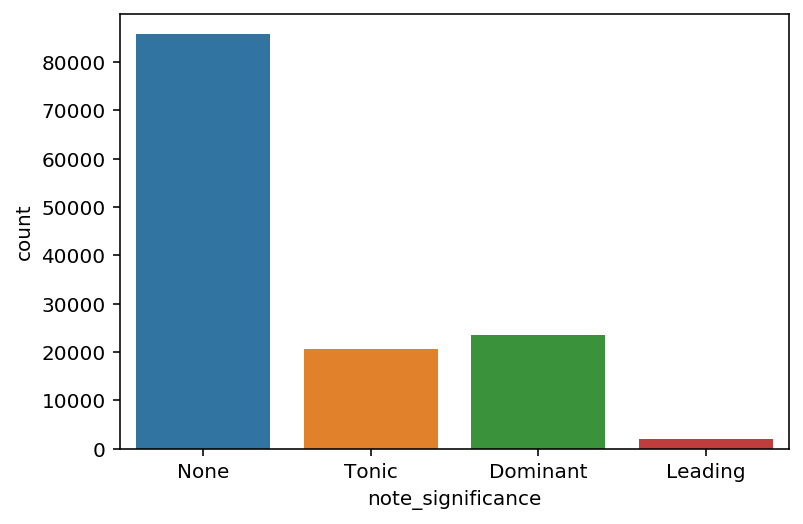

In [85]:
sns.countplot(frame['note_significance'].fillna("None"))
plt.show()

## Note significance according to hand


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/hist.py:342: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


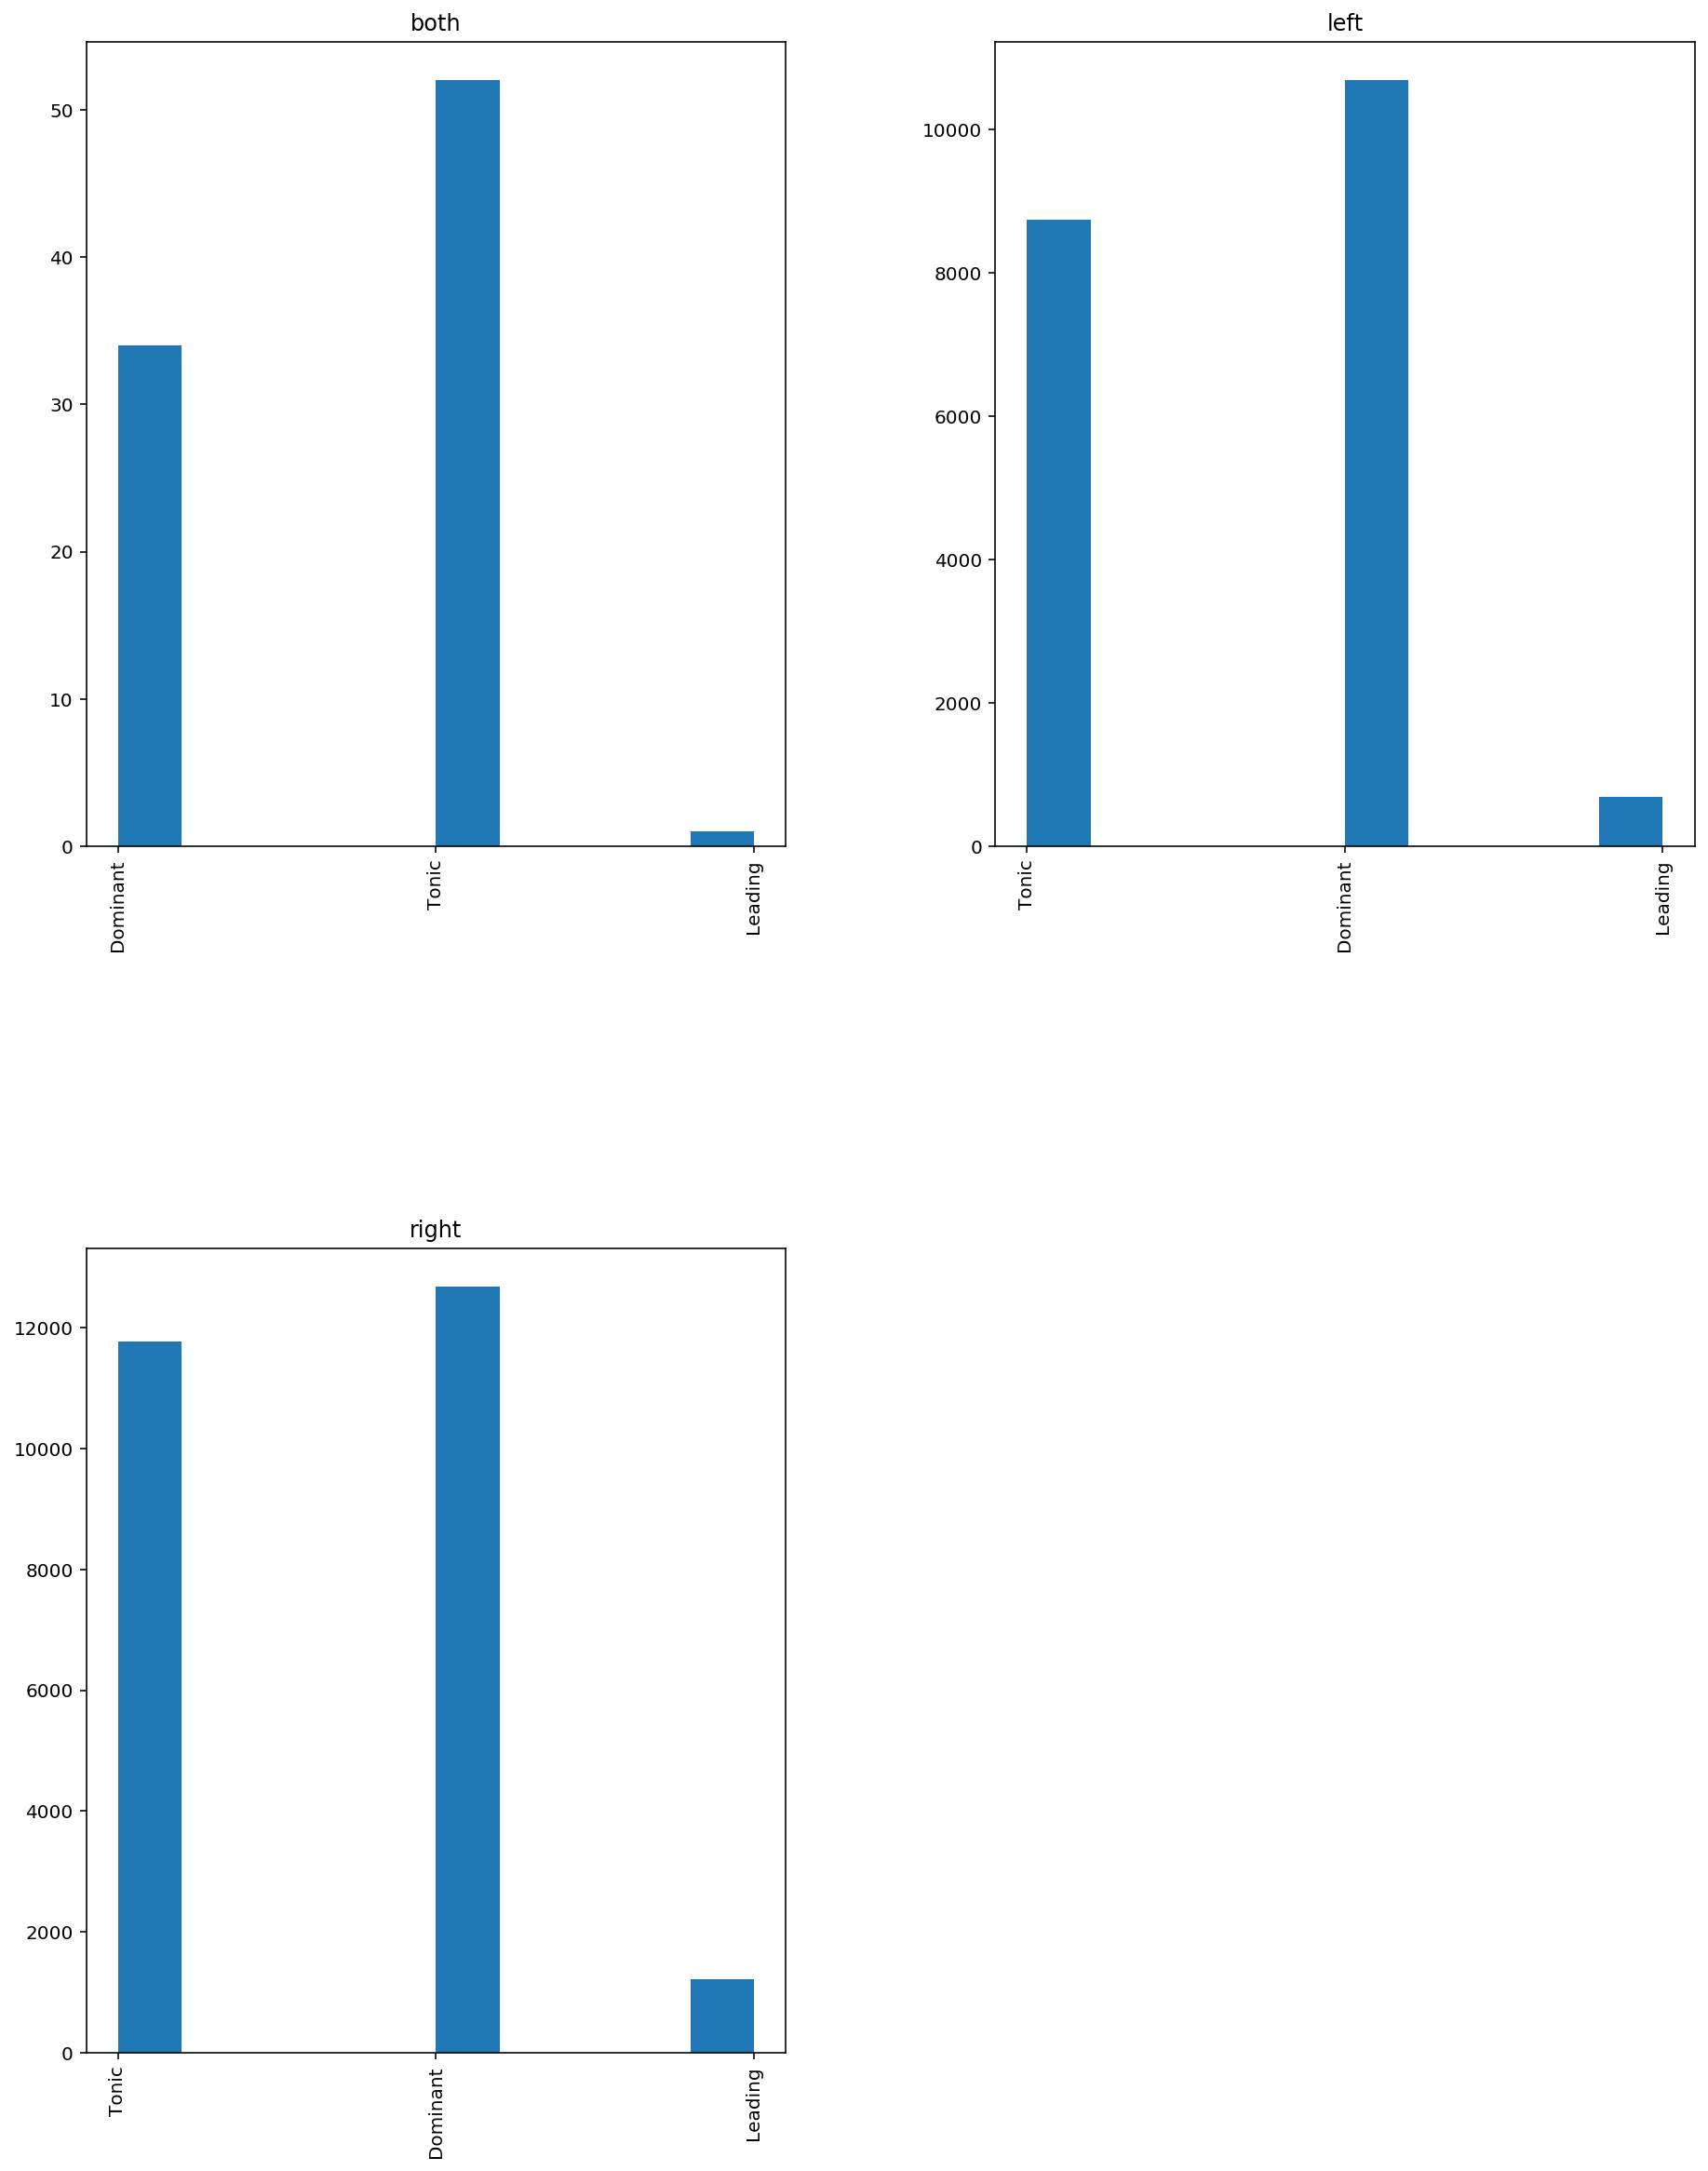

In [80]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
frame['note_significance'].hist(by=frame['hand'], ax=ax)
plt.show()

## Note significance according to stroke type

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/hist.py:342: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


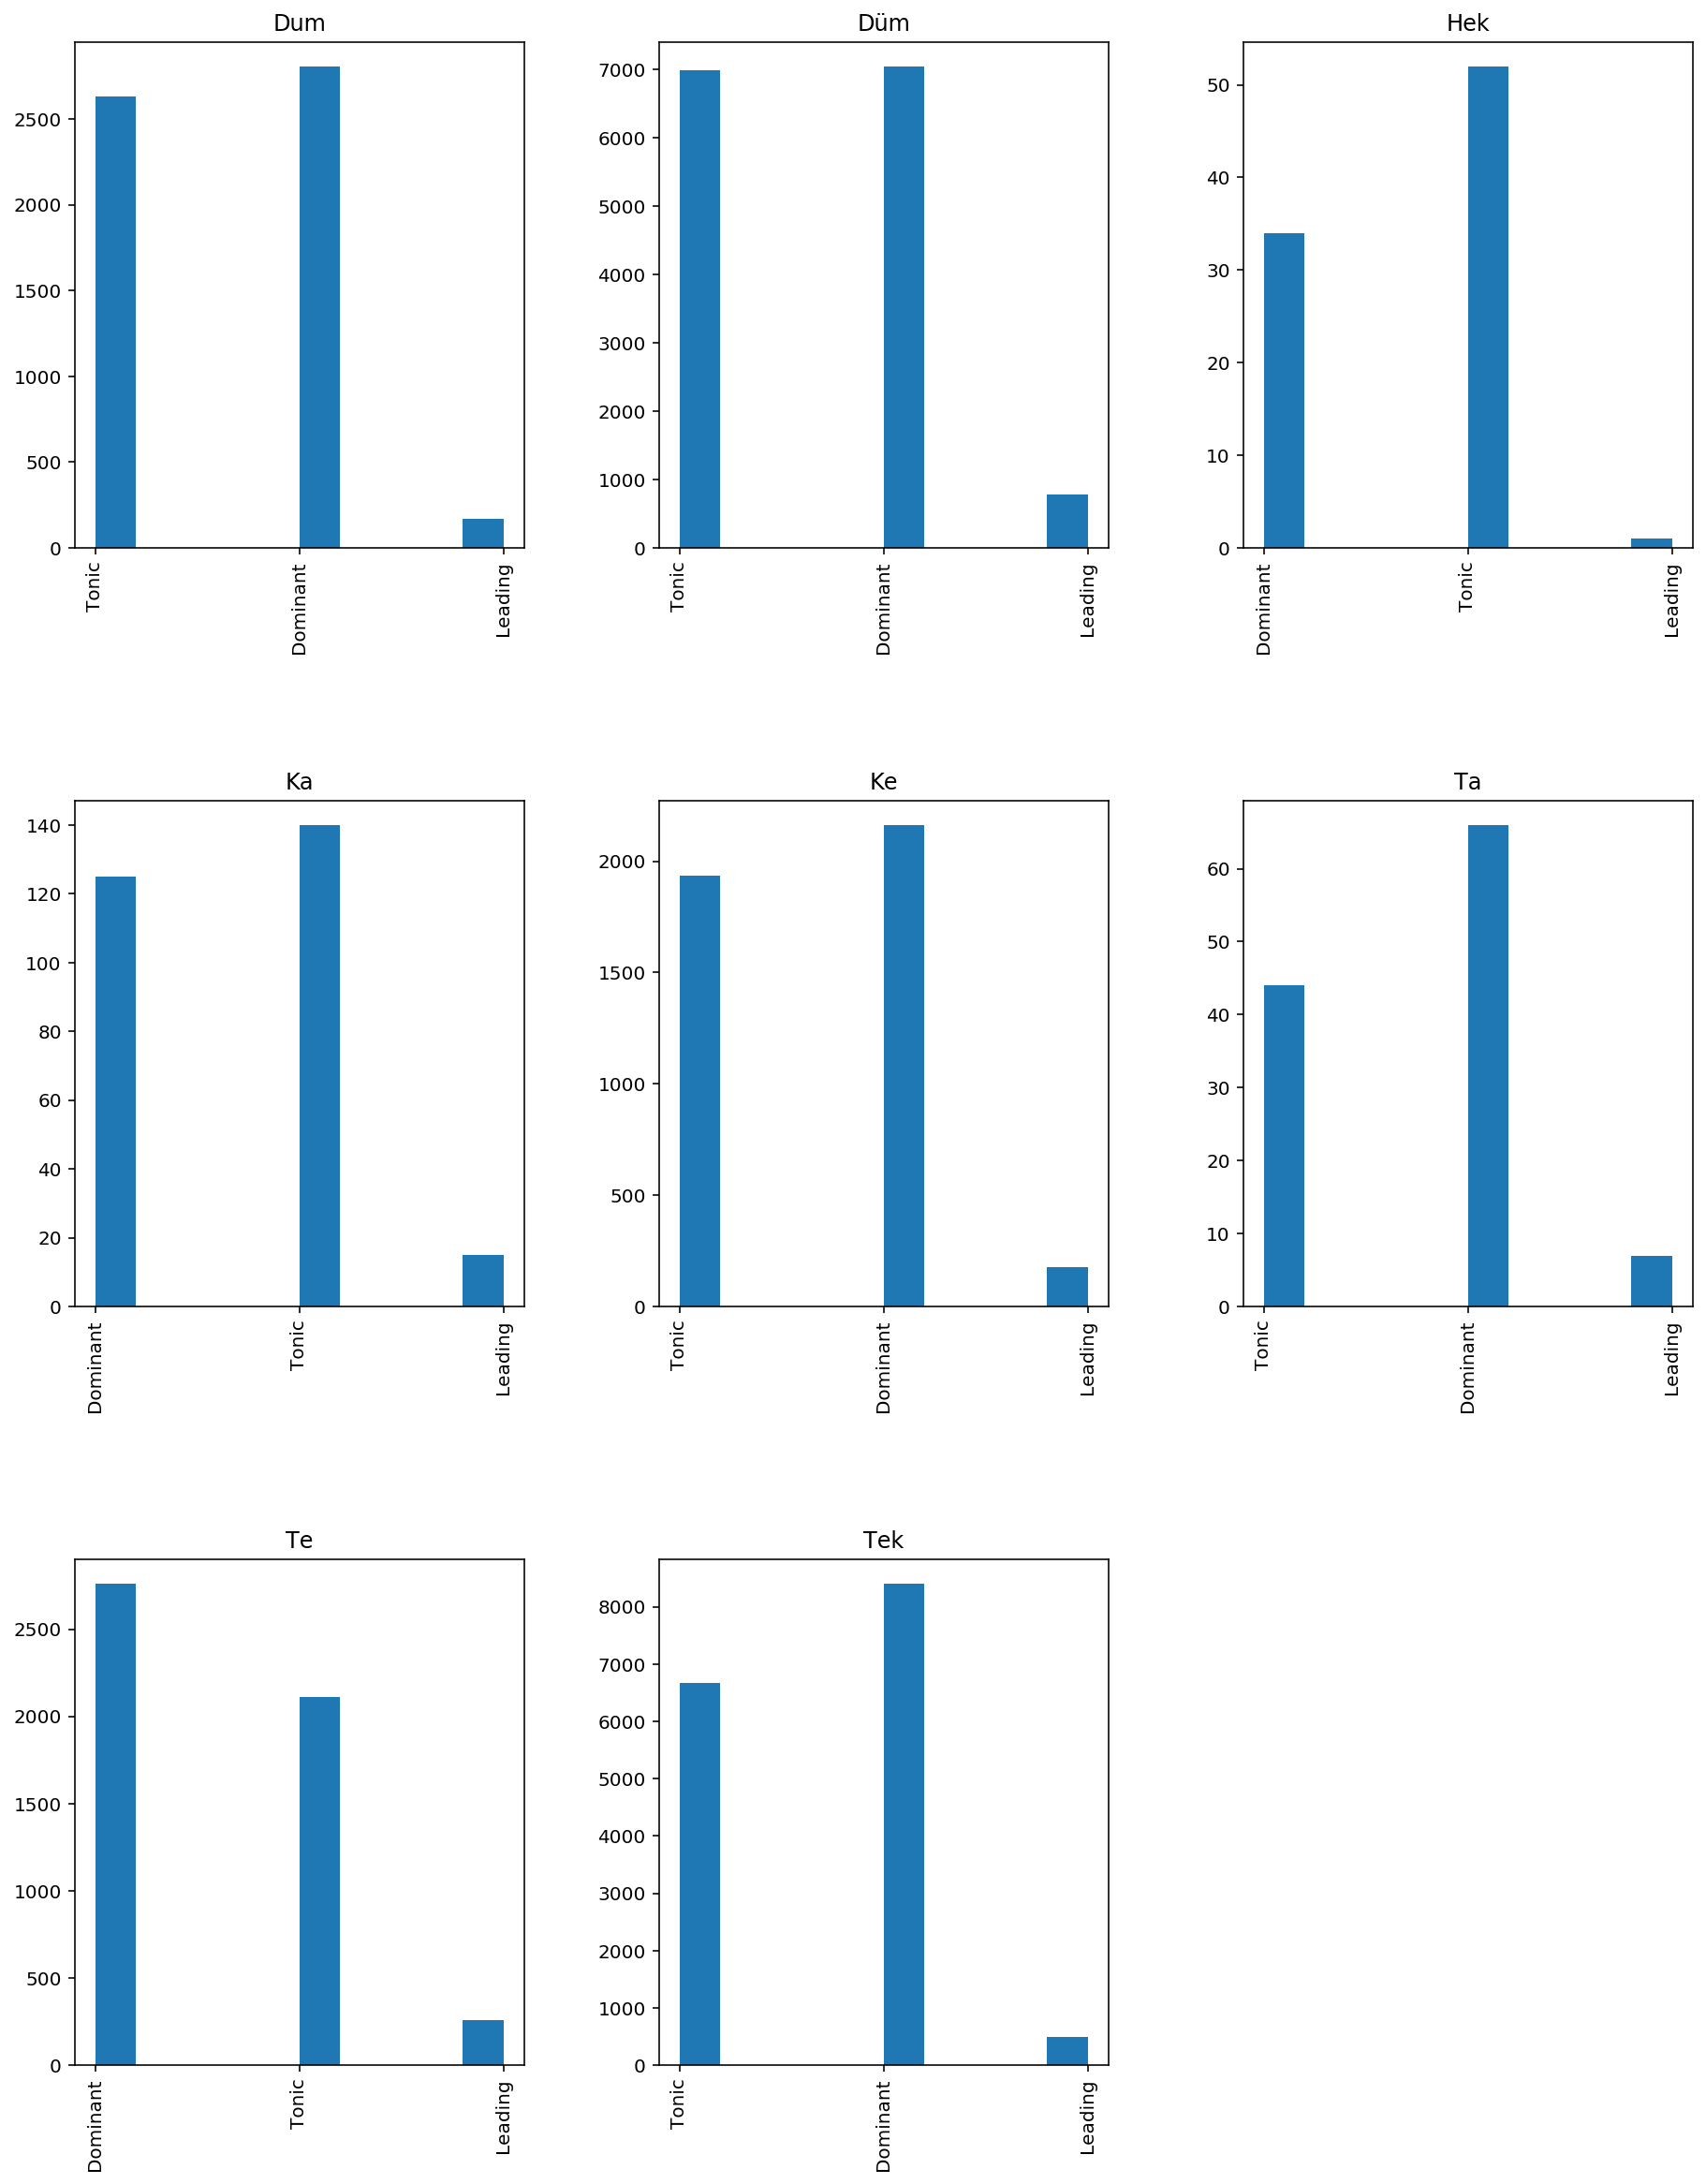

In [81]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
frame['note_significance'].hist(by=frame['stroke'], ax=ax)
plt.show()

## Note significance according to note duration

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/hist.py:342: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


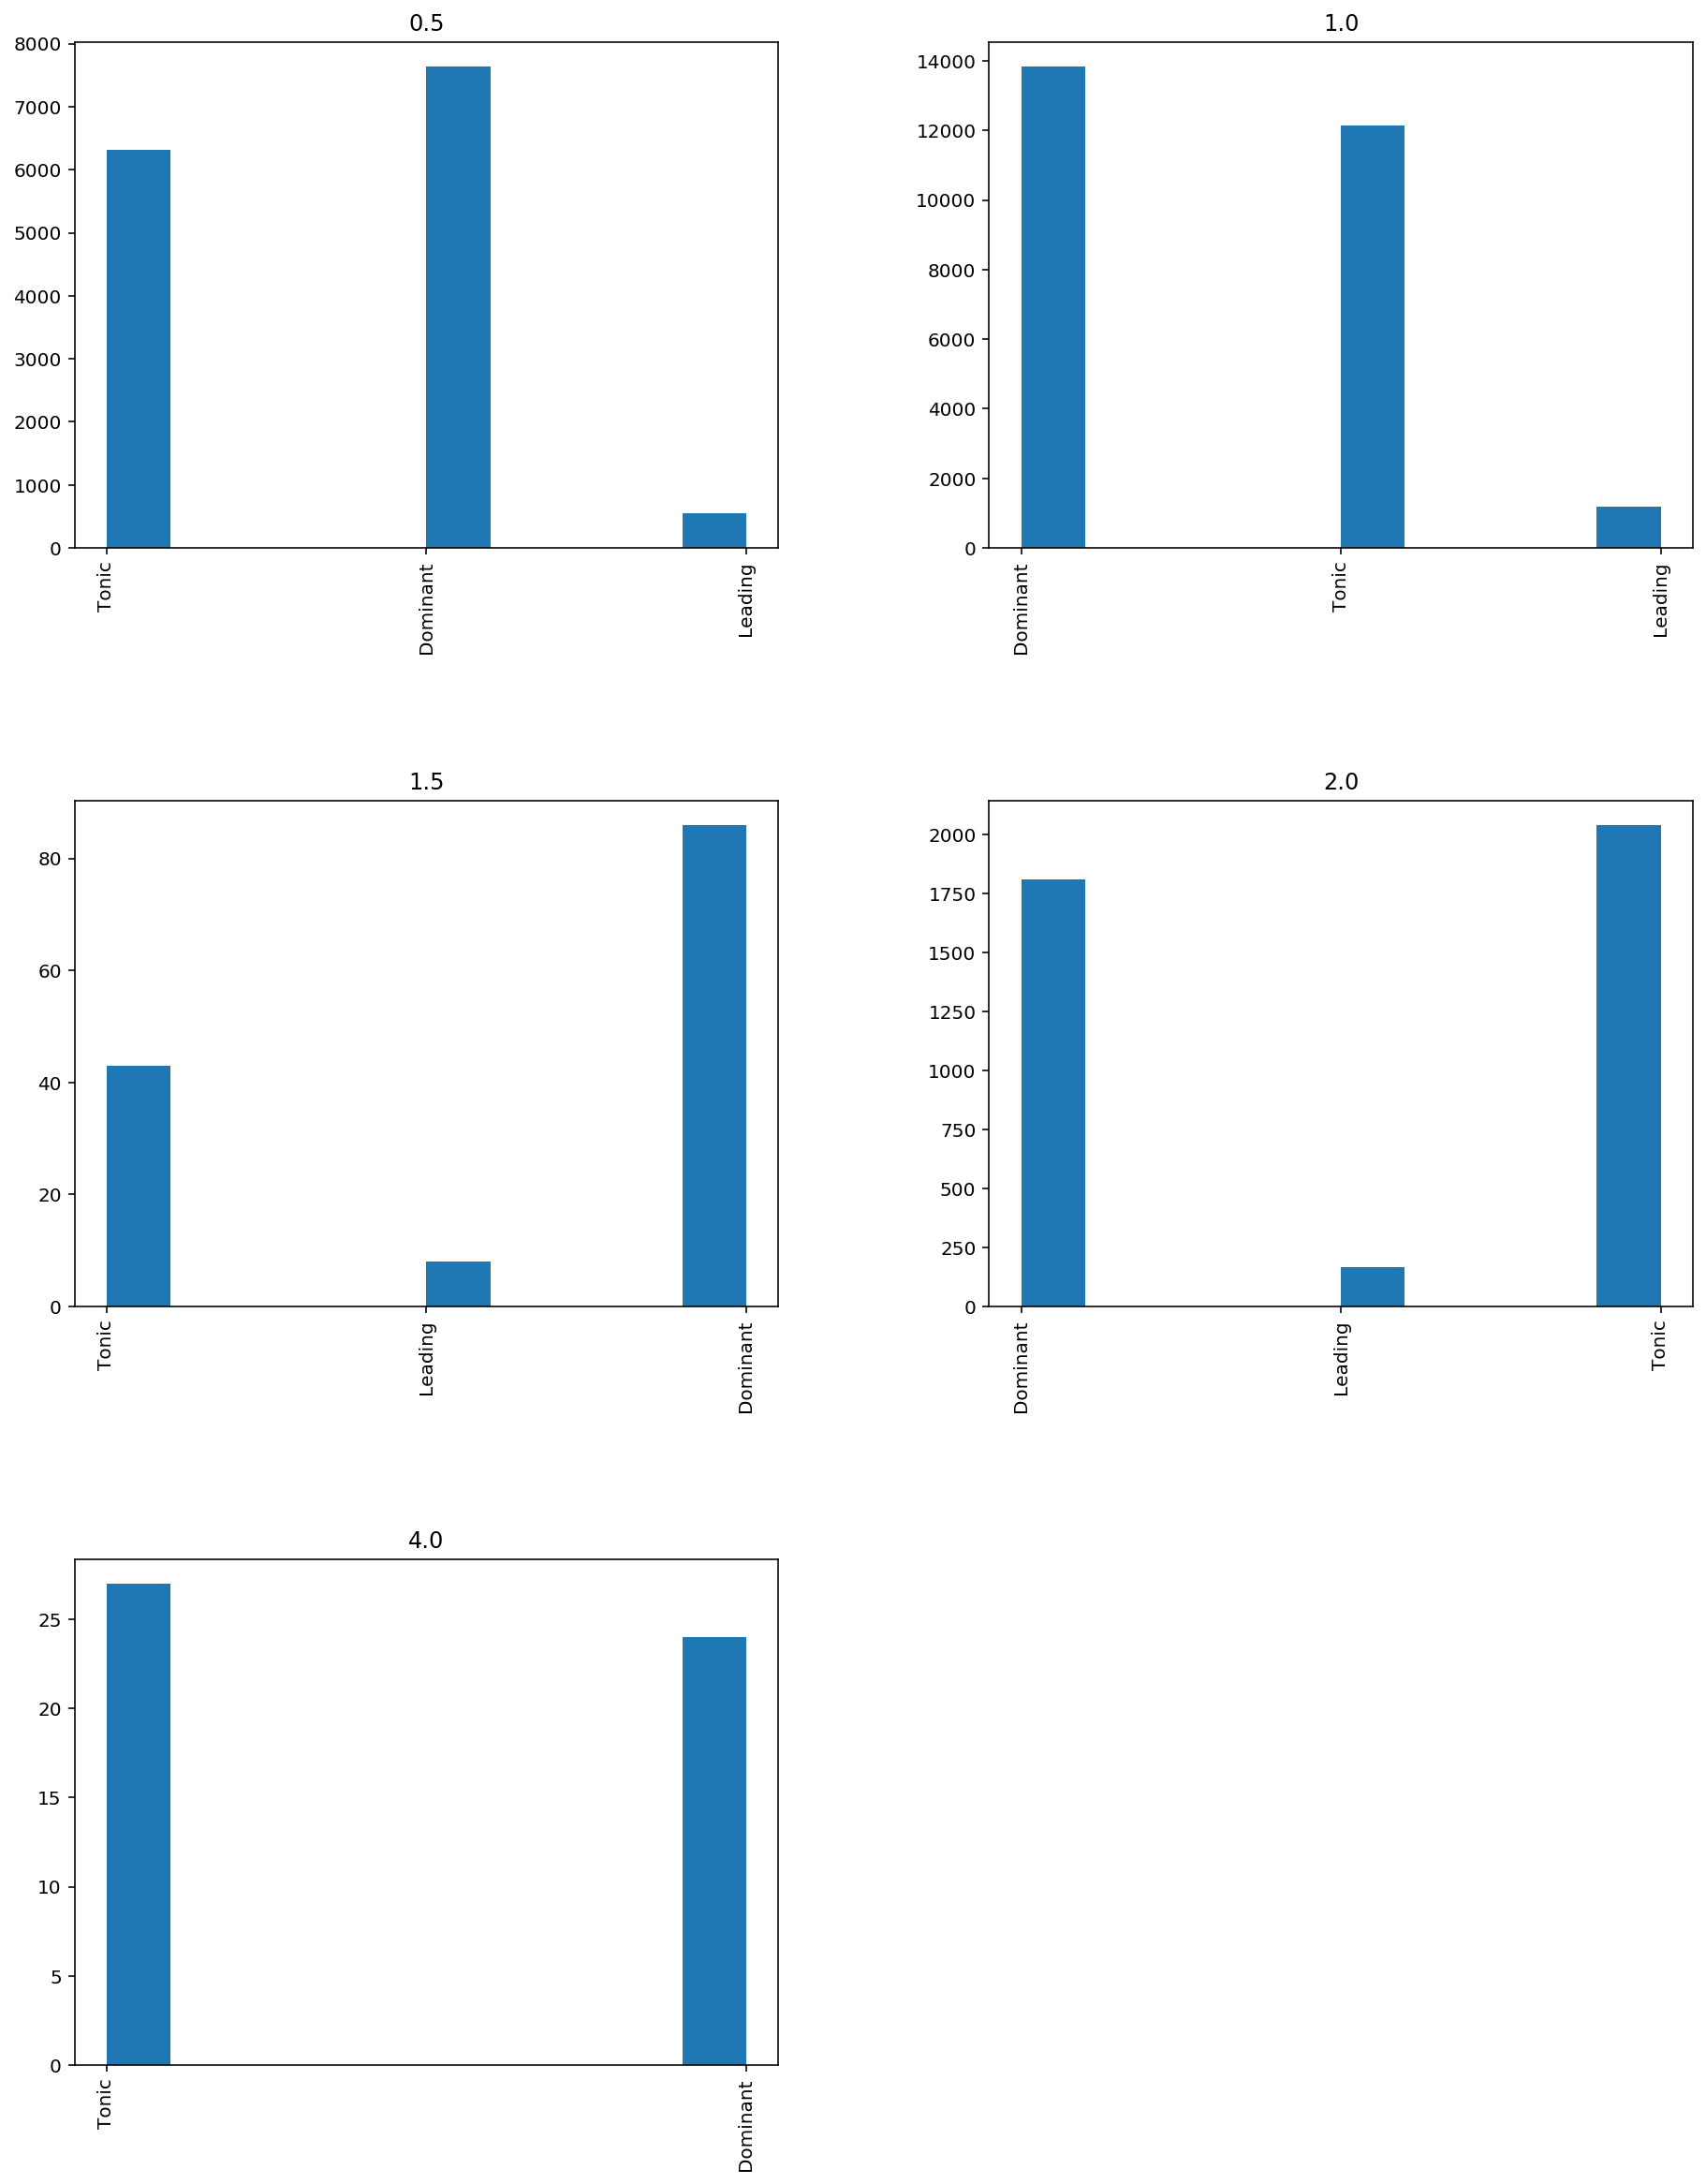

In [82]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
frame['note_significance'].hist(by=frame['duration'], ax=ax)
plt.show()

## Note significance according to makam

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/hist.py:342: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


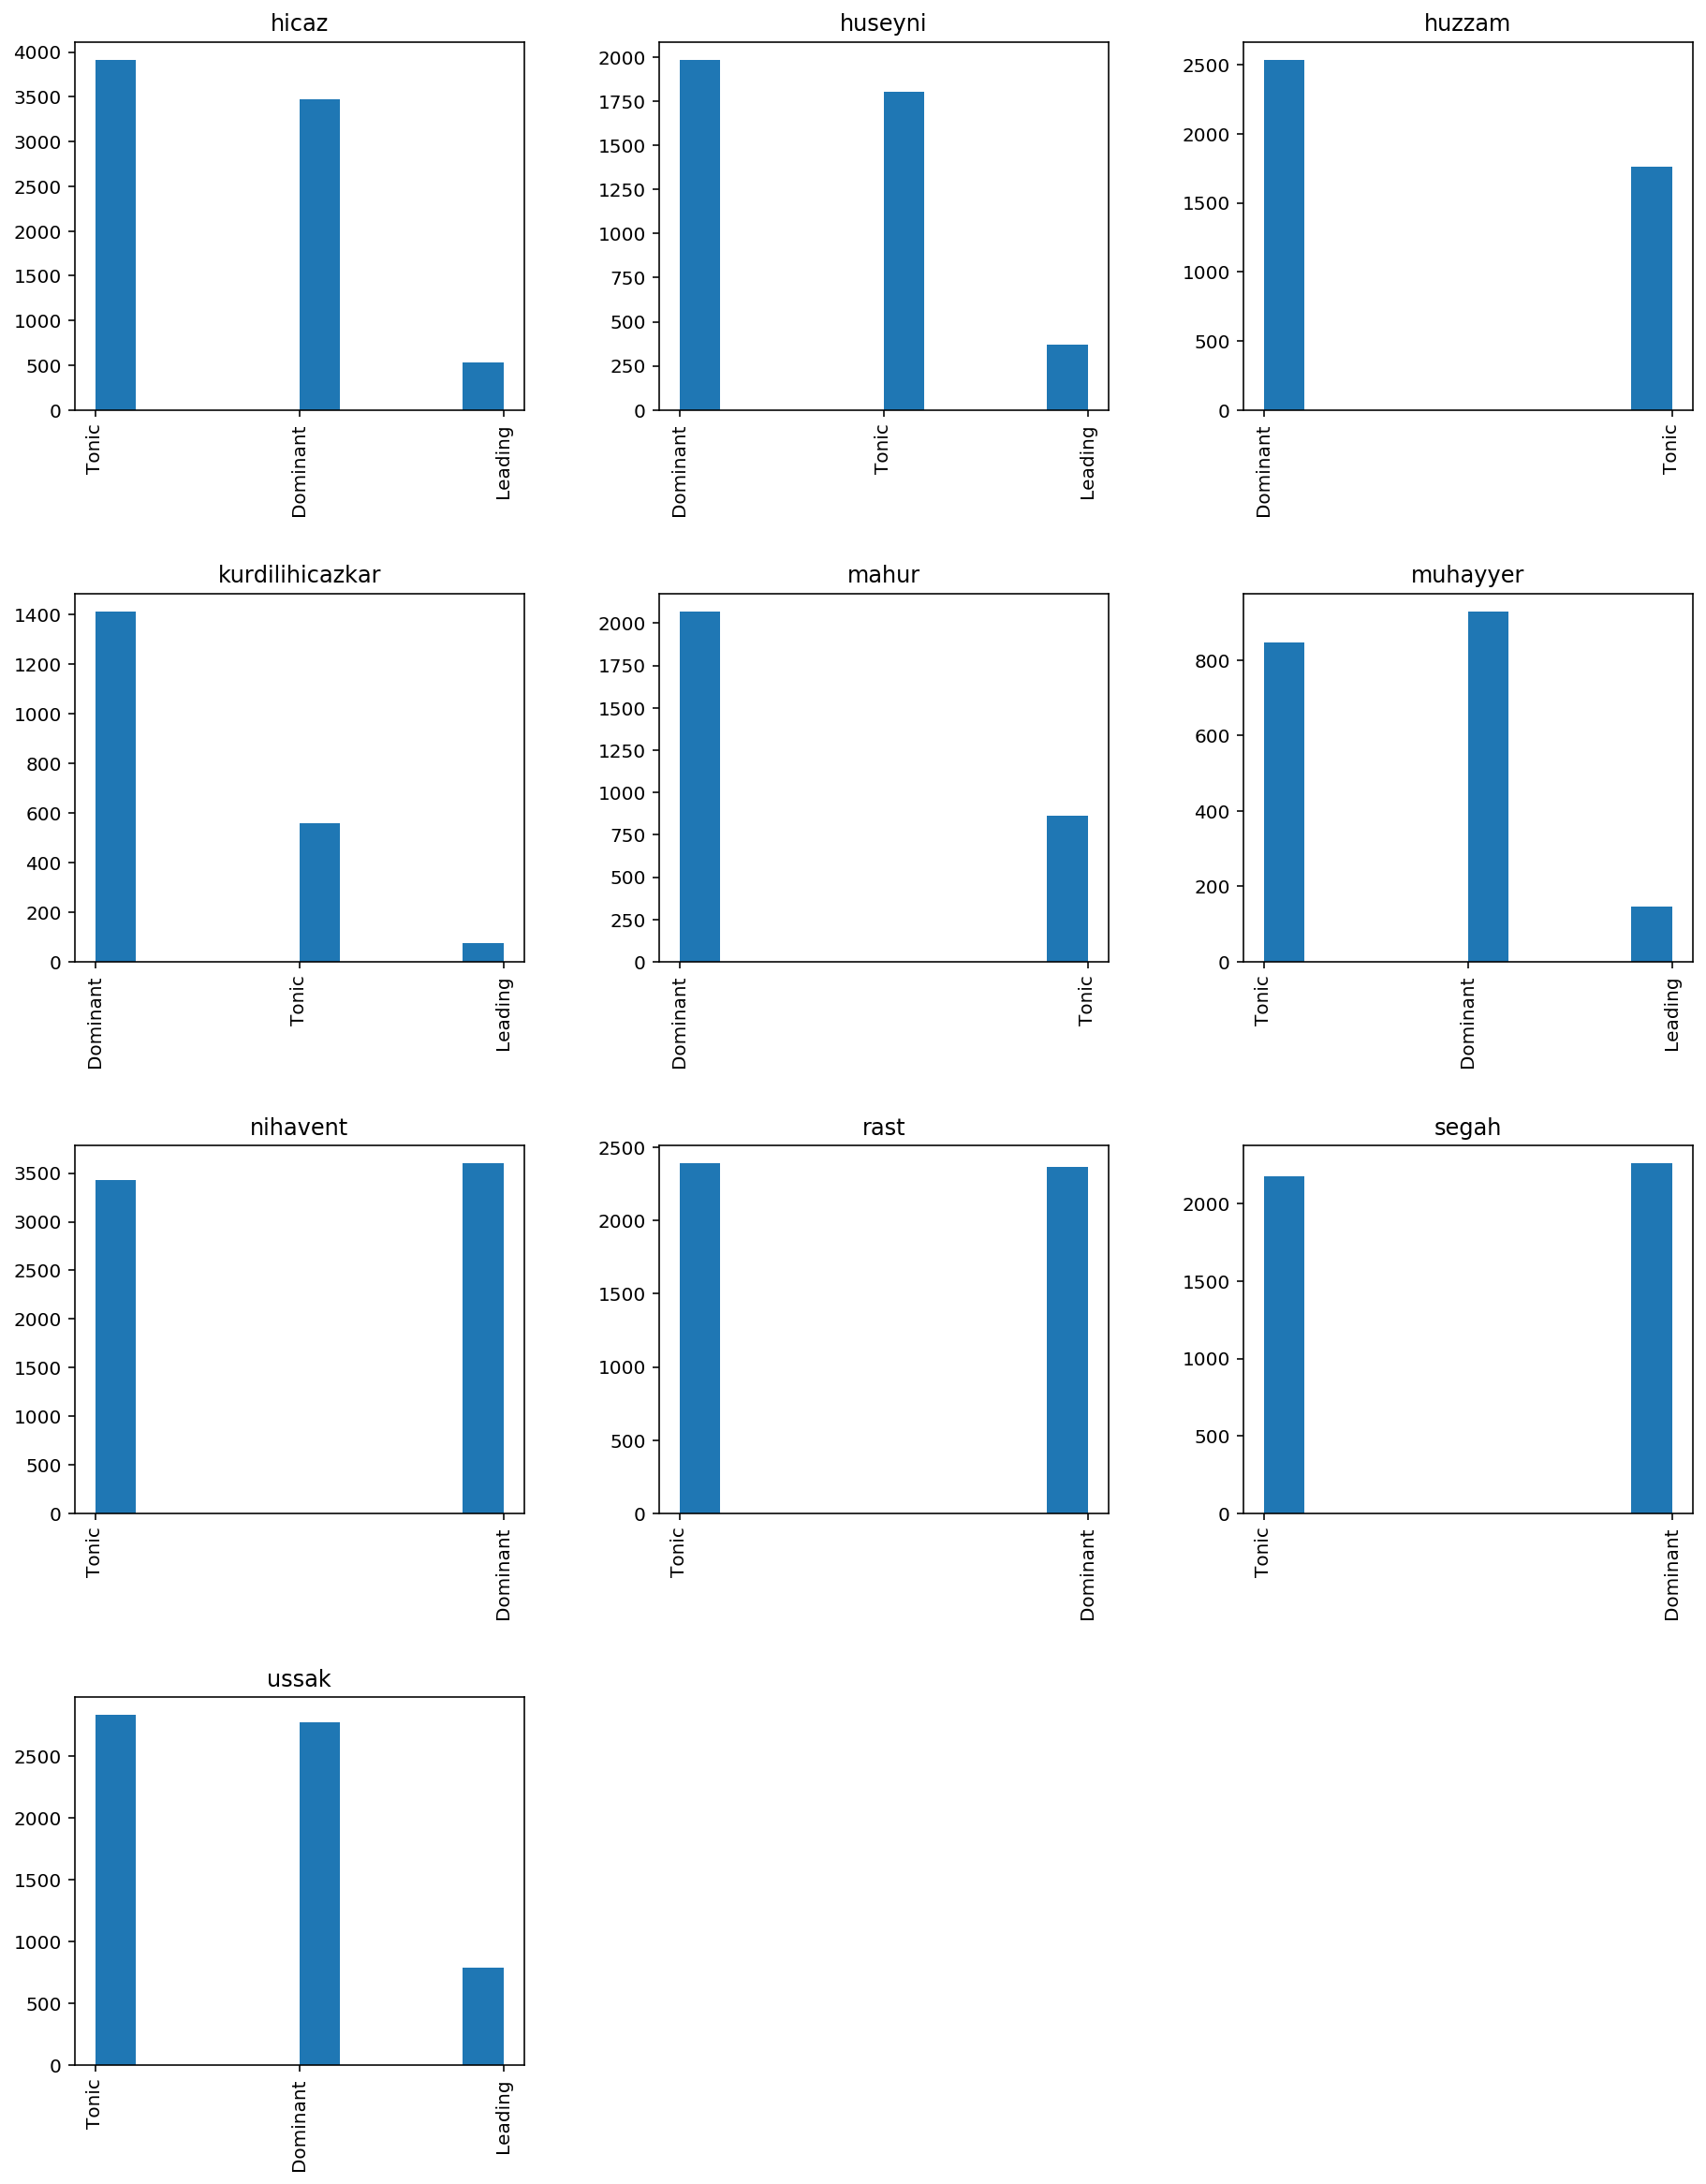

In [83]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
frame['note_significance'].hist(by=frame['makam'], ax=ax)
plt.show()

## Note significance according to Usul type

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/hist.py:342: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


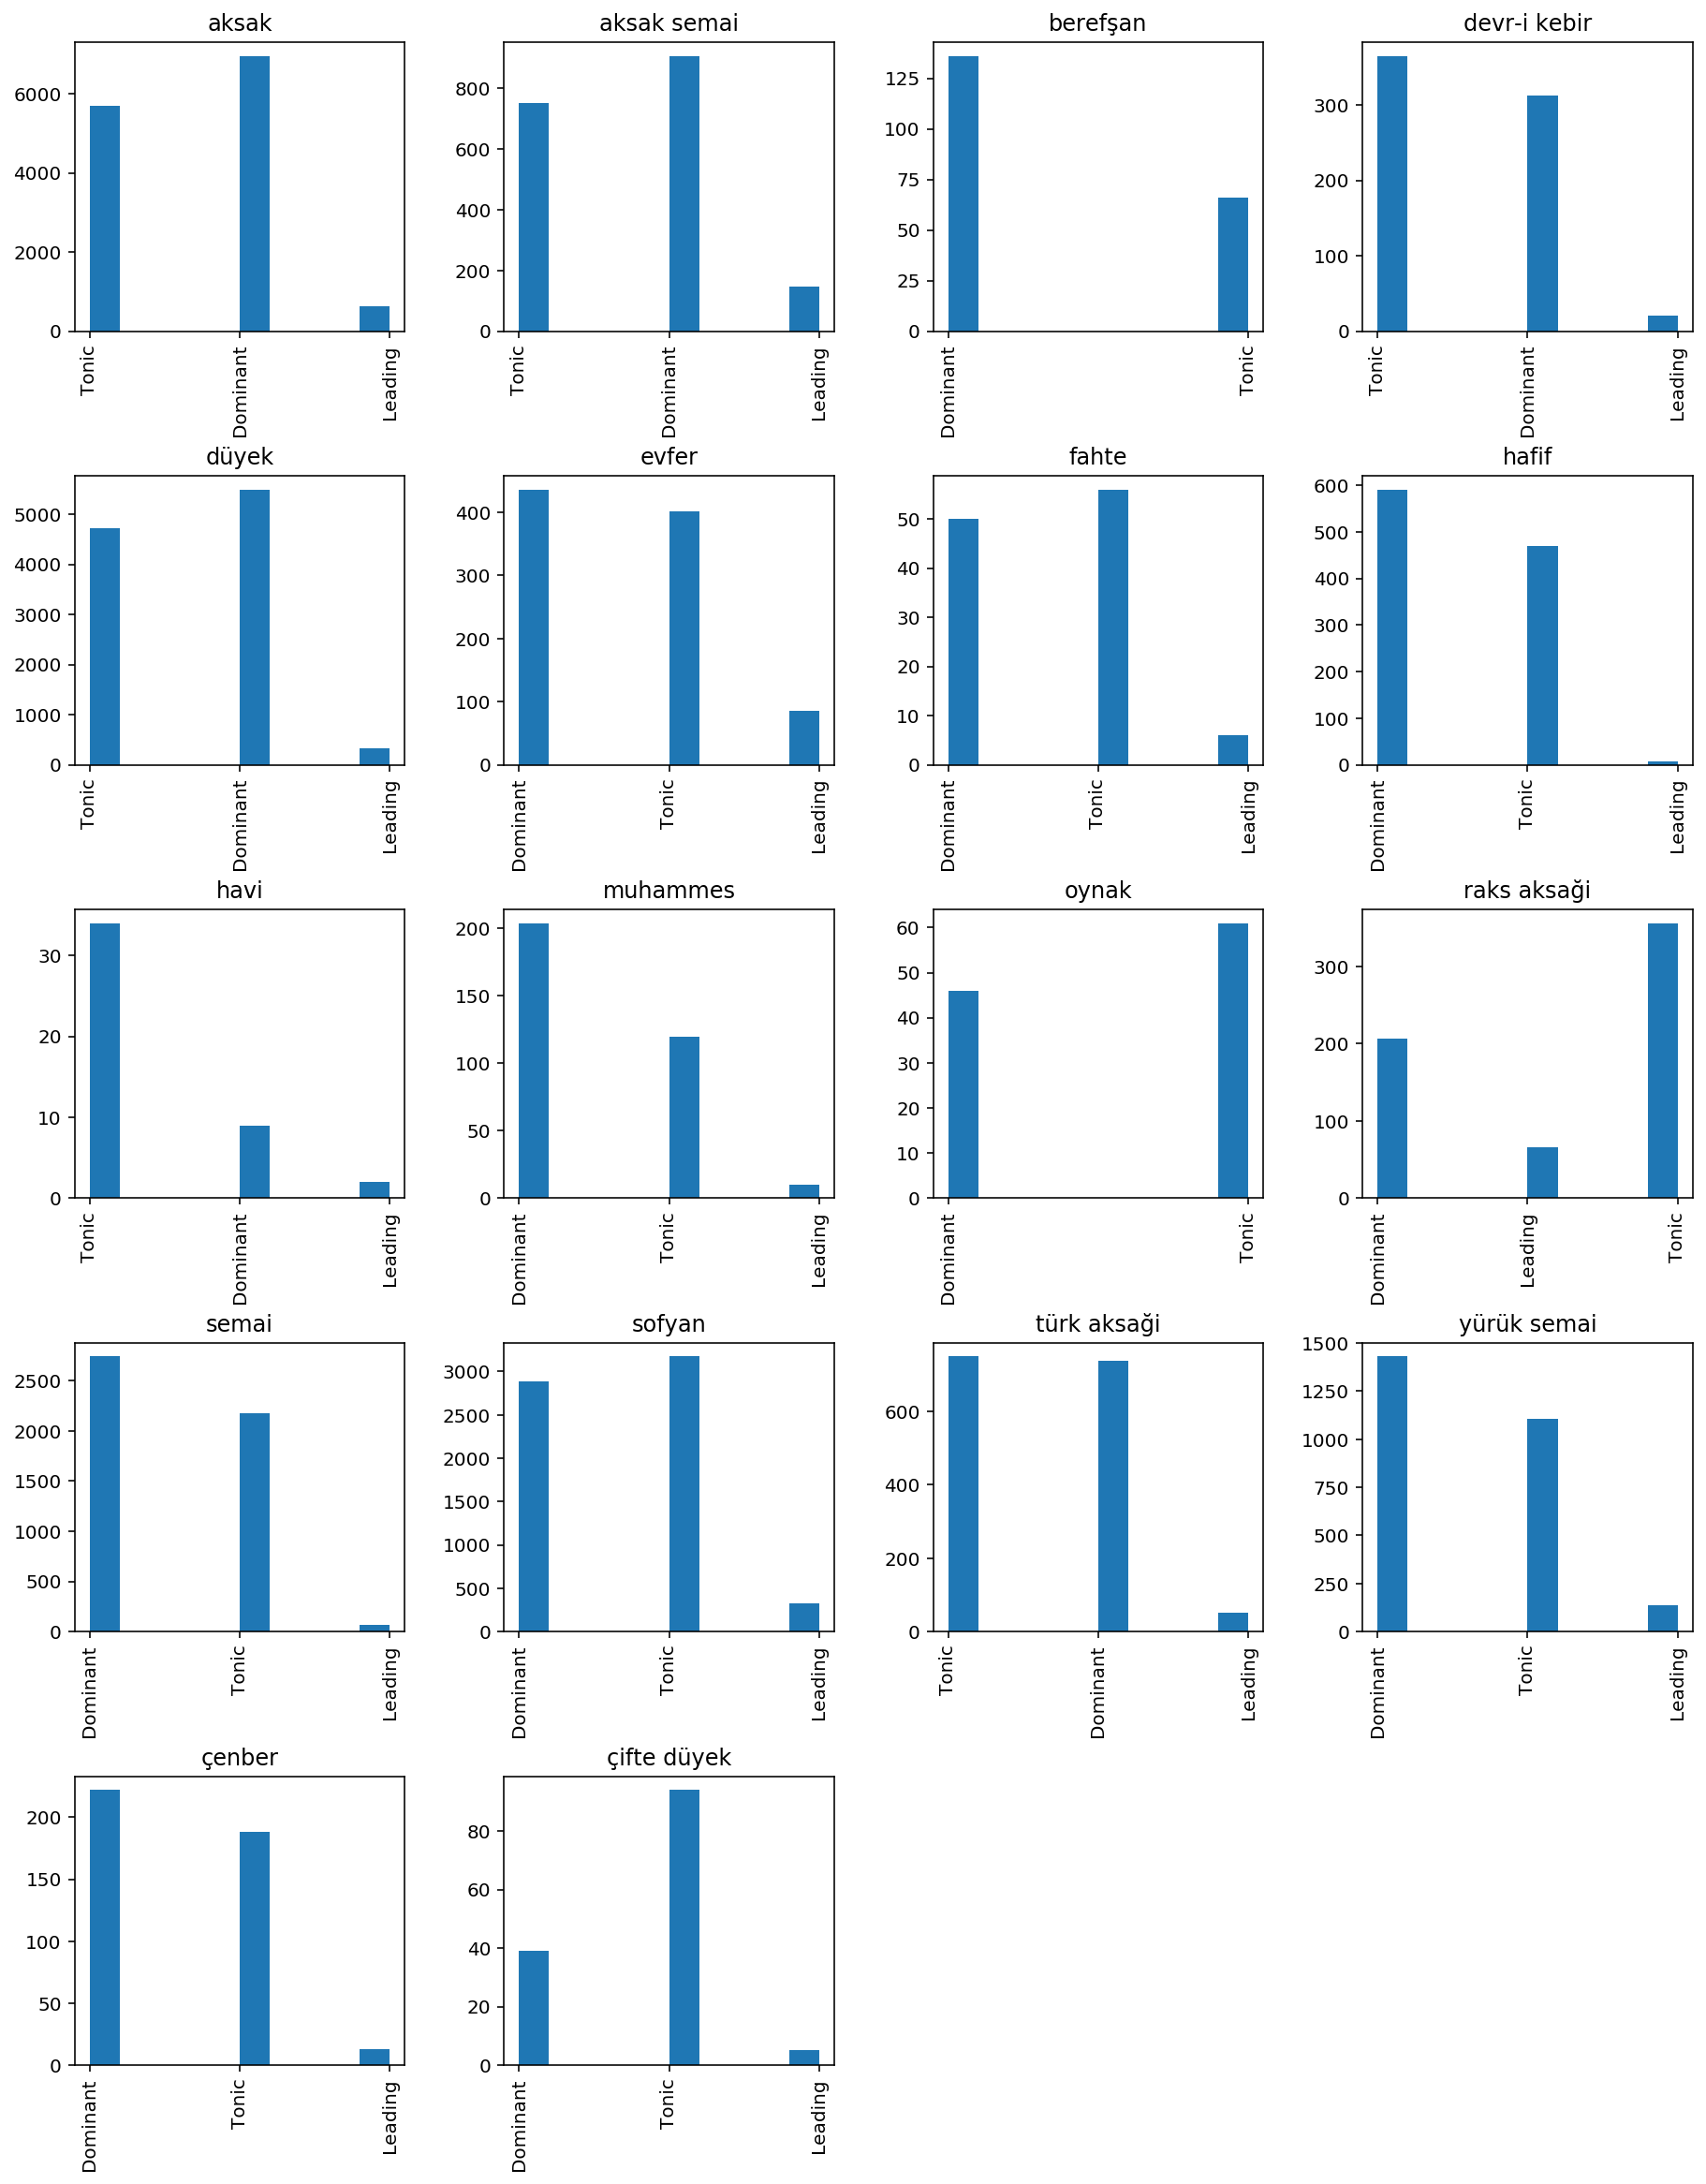

In [84]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
frame['note_significance'].hist(by=frame['usul'], ax=ax)
plt.show()